In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve

import pyroomacoustics as pra
import IPython

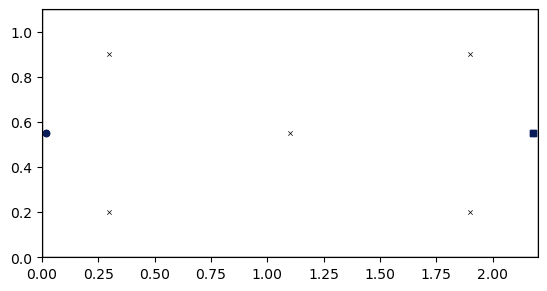

In [60]:
# 原始噪声信号
fs, signal = wavfile.read("google_speech_commands/_background_noise_/pink_noise.wav")

# 将信号缩短为 50000
signal = signal[0:50000]

# 创建房间的节点
corners = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T

# 向房间中添加信号源，首先构造一个 2D 房间，并设置房间的频率属性、ray_tracing、空气吸收率 (air_absorption)，最大阶数 (max_order)、材料 (materials) 参数进行设置，并生成新的 2D 房间 room 对象：
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15))

# 设置 ray_tracing 参数：接收半径 (receiver_radius)、n_ray、energy_thres
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# 使用 add_sorce() 方法在 [0.02, 0.55] 处添加信号源头 signal
# room.add_source([0.02, 0.55], signal=signal)

# 在房间内部添加五个信号监测点： []
E = np.array([[0.3, 1.9, 1.1, 0.3, 1.9], [0.2, 0.2, 0.55, 0.9, 0.9]])
room.add_microphone(E)

# 添加噪声源
room.add_source([0.02, 0.55], signal=signal)
# room.add_source([2.18, 0.55], signal=-signal)

# 使用 image_source_model() 类方法计算房间 room 的麦克风脉冲响应，并使用 simulate 方法进行房间仿真分析
room.image_source_model()
room.simulate()

# 绘制房间
fig, ax = room.plot()

In [54]:
# 原始噪声信号
print("Original Wave:")
IPython.display.Audio(signal, rate=fs)

Original Wave:


In [61]:
IPython.display.Audio(room.mic_array.signals[0,:], rate=fs)

In [62]:
IPython.display.Audio(room.mic_array.signals[1,:], rate=fs)

In [63]:
IPython.display.Audio(room.mic_array.signals[2,:], rate=fs)

In [64]:
IPython.display.Audio(room.mic_array.signals[3,:], rate=fs)

In [65]:
IPython.display.Audio(room.mic_array.signals[4,:], rate=fs)

### 下面为单输入但输出 (SISO) ANC 的代码设计

In [18]:
# 下面通过 pyroom 一个降噪麦克风的例子，成功！！！！！！！！！！！！！！！！

# 原始噪声信号
fs, signal = wavfile.read("google_speech_commands/_background_noise_/pink_noise.wav")

# 将信号缩短为 50000
signal = signal[0:50000]

# 创建房间的节点
corners = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T

# 创建房间的节点
corners = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T

# 向房间中添加信号源，首先构造一个 2D 房间，并设置房间的频率属性、ray_tracing、空气吸收率 (air_absorption)，最大阶数 (max_order)、材料 (materials) 参数进行设置，并生成新的 2D 房间 room 对象：
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15))

# 设置 ray_tracing 参数：接收半径 (receiver_radius)、n_ray、energy_thres
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# 使用 add_sorce() 方法在 [0.02, 0.55] 处添加信号源头 signal
room.add_source([0.02, 0.55], signal=signal)

# 在房间内部添加五个信号监测点： []
E = np.array([[0.3, 1.9, 1.1, 0.3, 1.9], [0.2, 0.2, 0.55, 0.9, 0.9]])
room.add_microphone(E)

# 绘制房间
# fig, ax = room_d.plot()

# 对房间进行仿真
room.image_source_model()
room.simulate()


##### 下面进行降噪算法设计 #####
# 设计降噪声源信号
length = 15         # 滤波器长度

# 设置滤波器参数
w = np.random.randn(length)     # 滤波器参数
w /= np.linalg.norm(w)          # 对滤波器参数进行范数正则化处理

adfilt_nlms = dict(
        filter = pra.adaptive.NLMS(length, mu=0.5),
        error = np.zeros(50000),
    )

for i in range(50000):
    adfilt_nlms['filter'].update(signal[i], room.mic_array.signals[0,i])
    adfilt_nlms['error'][i] = np.linalg.norm(adfilt_nlms['filter'].w - w)

# 降噪信号
d_signal = fftconvolve(signal, adfilt_nlms['filter'].w)[:50000]

room_d = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15))

# 设置 ray_tracing 参数：接收半径 (receiver_radius)、n_ray、energy_thres
room_d.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

room_d.add_source([0.02, 0.55], signal=signal)
room_d.add_source([2.18, 0.55], signal=d_signal)

E = np.array([[0.3, 1.9, 1.1, 0.3, 1.9], [0.2, 0.2, 0.55, 0.9, 0.9]])
room_d.add_microphone(E)

room_d.image_source_model()
room_d.simulate()

In [11]:
# 原始噪声信号
print("Original Wave:")
IPython.display.Audio(signal, rate=fs)

Original Wave:


In [12]:
IPython.display.Audio(room_d.mic_array.signals[0,:], rate=fs)

In [13]:
IPython.display.Audio(room_d.mic_array.signals[1,:], rate=fs)

In [14]:
IPython.display.Audio(room_d.mic_array.signals[2,:], rate=fs)

In [15]:
IPython.display.Audio(room_d.mic_array.signals[3,:], rate=fs)

In [16]:
IPython.display.Audio(room_d.mic_array.signals[4,:], rate=fs)

### 下面设计多输入多输出 (MIMO) 的 ANC 设计

In [ ]:
# 下面通过 pyroom 一个降噪麦克风的例子，成功！！！！！！！！！！！！！！！！

# 原始噪声信号
fs, signal = wavfile.read("google_speech_commands/_background_noise_/pink_noise.wav")

# 将信号缩短为 50000
signal = signal[0:50000]

# 创建房间的节点
corners = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T

# 创建房间的节点
corners = np.array([[0, 0], [0, 1.1], [2.2, 1.1], [2.2, 0]]).T

# 向房间中添加信号源，首先构造一个 2D 房间，并设置房间的频率属性、ray_tracing、空气吸收率 (air_absorption)，最大阶数 (max_order)、材料 (materials) 参数进行设置，并生成新的 2D 房间 room 对象：
room = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15))

# 设置 ray_tracing 参数：接收半径 (receiver_radius)、n_ray、energy_thres
room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

# 使用 add_sorce() 方法在 [0.02, 0.55] 处添加信号源头 signal
room.add_source([0.02, 0.55], signal=signal)

# 在房间内部添加五个信号监测点： []
E = np.array([[0.3, 1.9, 1.1, 0.3, 1.9], [0.2, 0.2, 0.55, 0.9, 0.9]])
room.add_microphone(E)

# 绘制房间
# fig, ax = room_d.plot()

# 对房间进行仿真
room.image_source_model()
room.simulate()


##### 下面进行降噪算法设计 #####
# 设计降噪声源信号
length = 15         # 滤波器长度

# 设置滤波器参数，与 SISO 不同，这里设置的滤波器参数的维度为 5 * 15，其中 5 表示
w = np.random.randn(length)     # 滤波器参数
w /= np.linalg.norm(w)          # 对滤波器参数进行范数正则化处理

adfilt_nlms = dict(
        filter = pra.adaptive.NLMS(length, mu=0.5),
        error = np.zeros(50000),
    )

for i in range(50000):
    adfilt_nlms['filter'].update(signal[i], room.mic_array.signals[0,i])
    adfilt_nlms['error'][i] = np.linalg.norm(adfilt_nlms['filter'].w - w)

# 降噪信号
d_signal = fftconvolve(signal, adfilt_nlms['filter'].w)[:50000]

room_d = pra.Room.from_corners(corners, fs=fs, ray_tracing=True, max_order=3, materials=pra.Material(0.2, 0.15))

# 设置 ray_tracing 参数：接收半径 (receiver_radius)、n_ray、energy_thres
room_d.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)

room_d.add_source([0.02, 0.55], signal=signal)
room_d.add_source([2.18, 0.55], signal=d_signal)

E = np.array([[0.3, 1.9, 1.1, 0.3, 1.9], [0.2, 0.2, 0.55, 0.9, 0.9]])
room_d.add_microphone(E)

room_d.image_source_model()
room_d.simulate()

In [ ]:
from pymoo.core.problem import ElementwiseProblem

# 下面设计基于 GA 的第二通道信号生成方法
class MyProblem(ElementwiseProblem):

    def __init__(self, elementwise=True, **kwargs):
        super().__init__(
            n_var=4,
            n_obj=5,
            n_ieq_constr=5,
            # xl=np.array([np.min(signal), np.min(signal), np.min(signal), np.min(signal), np.min(signal)]),
            # xu=np.array([[np.max(signal), np.max(signal), np.max(signal), np.max(signal), np.max(signal)]])
            xl=0,
            xu=5
        )

    def _evaluate(self, x, out, *args, **kwargs):
        global i
        i = 0
        room.add_source([0.02, 0.55], signal=signal[i])
        i = i + 1
        room.image_source_model()   # 得到房间的 RIR
        room.simulate()             # 为了得到麦克风的信号

        # f1 = room.mic_array.signals[0]
        # f2 = room.mic_array.signals[1]
        # f3 = room.mic_array.signals[2]
        # f4 = room.mic_array.signals[3]
        # f5 = room.mic_array.signals[4]

        f1 = room.add_source([2.18, 1.08], signal=x[0]) 
        f2 = x[1]
        f3 = x[2]
        f4 = x[3]
        f5 = x[4]

        g1 = -f1
        g2 = -f2
        g3 = -f3
        g4 = -f4
        g5 = -f5

        out["F"] = [f1, f2, f3, f4, f5]
        out["G"] = [g1, g2, g3, g4, g5]

In [ ]:
from pymoo.problems.functional import FunctionalProblem

objs = [
    lambda x: 
]